In [13]:
import numpy as np
import os
import torch 
import torch.nn as nn
import torch.optim as optim

class my_rnn_cell(nn.Module):
    def __init__(self, inp_size, h_size):
        super(my_rnn_cell, self).__init__()
        # initializations
        self.inp_size = inp_size
        self.h_size = h_size
        
        self.fc1 = nn.Linear(inp_size, h_size)  # input weights learnable
        self.fc2 = nn.Linear(h_size, h_size)    # hidden weights learnable

    def forward(self, x, h):
        x_u = self.fc1(x)        # transform input
        h_v = self.fc2(h)        # transform previous hidden state
        new_h = torch.tanh(x_u + h_v)  # new hidden state

        return new_h

class my_rnn(nn.Module):
    def __init__(self, inp_size, h_size, out_size):
        super(my_rnn, self).__init__()
        # initializations
        self.inp_size = inp_size
        self.h_size = h_size
        
        self.rnn_cell = my_rnn_cell(inp_size, h_size)
        self.fc = nn.Linear(h_size, out_size)  # output layer

    def forward(self, x):  # x is seq of inputs with shape [seq_len, batch_size, inp_size]
        batch_size = x.size(1)

        # Initialize hidden state
        h = torch.zeros(batch_size, self.h_size, device=x.device)
        
        outputs = []
        hidden_states = []
        
        for t in range(len(x)):
            h = self.rnn_cell(x[t], h)  # Update hidden state
            hidden_states.append(h)
            output = self.fc(h)         # Get output prediction
            outputs.append(output)
            
        # Stack outputs and hidden states along sequence dimension
        outputs = torch.stack(outputs, dim=0)
        hidden_states = torch.stack(hidden_states, dim=0)
            
        return outputs, h  # Return all outputs and final hidden state

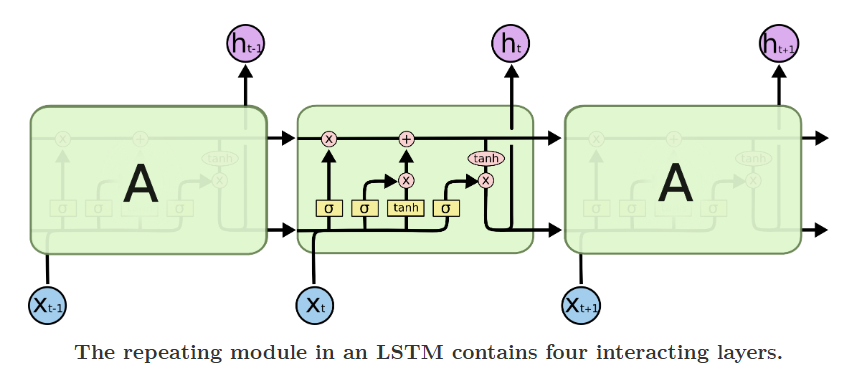

In [ ]:
class my_lstm_cell(nn.Module):
    def __init__(self, inp_size, h_size):
        super(my_lstm_cell, self).__init__()
        # initializations
        self.inp_size = inp_size
        self.h_size = h_size
        # Input weights
        self.x_w_i = nn.Linear(inp_size, h_size)  # input gate
        self.x_w_f = nn.Linear(inp_size, h_size)  # forget gate
        self.x_w_o = nn.Linear(inp_size, h_size)  # output gate
        self.x_w_c = nn.Linear(inp_size, h_size)  # cell gate
        
        # Hidden weights
        self.h_w_i = nn.Linear(h_size, h_size)
        self.h_w_f = nn.Linear(h_size, h_size)
        self.h_w_o = nn.Linear(h_size, h_size)
        self.h_w_c = nn.Linear(h_size, h_size)  # cell gate

    def forward(self, x, c, h):
        # Gates
        i = torch.sigmoid(self.x_w_i(x) + self.h_w_i(h))  # input gate
        f = torch.sigmoid(self.x_w_f(x) + self.h_w_f(h))  # forget gate
        o = torch.sigmoid(self.x_w_o(x) + self.h_w_o(h))  # output gate
        
        # New cell candidate (missing in original)
        c_tilde = torch.tanh(self.x_w_c(x) + self.h_w_c(h))
        
        # Update cell state
        new_c = (f * c) + (i * c_tilde) 
        
        # Generate new hidden state
        new_h = o * torch.tanh(new_c)
        
        return new_c, new_h

class my_lstm(nn.Module):
    def __init__(self, inp_size, h_size, out_size):
        super(my_lstm, self).__init__()
        # initializations
        self.inp_size = inp_size
        self.h_size = h_size
        
        self.lstm_cell = my_lstm_cell(inp_size, h_size)
        self.fc = nn.Linear(h_size, out_size)  # fixed typo: Linaer -> Linear

    def forward(self, x):  # x is seq of inputs with shape [seq_len, batch_size, inp_size]
        batch_size = x.size(1)
        h_size = self.fc.in_features
        
        # Initialize hidden and cell states
        h = torch.zeros(batch_size, h_size, device=x.device)
        c = torch.zeros(batch_size, h_size, device=x.device)
        
        outputs = []
        
        for t in range(len(x)):
            c, h = self.lstm_cell(x[t], c, h)  # was using x instead of x[t]
            outputs.append(self.fc(h))  # should use h not o for output projection
        
        # Stack outputs along sequence dimension
        outputs = torch.stack(outputs, dim=0)
            
        return outputs, (h, c)  # Return outputs and final states (h, c)

In [3]:
##BUILT IN
# For comparison, let's also include PyTorch's built-in implementations
class torch_rnn(nn.Module):
    def __init__(self, inp_size, h_size, out_size):
        super(torch_rnn, self).__init__()
        self.rnn = nn.RNN(inp_size, h_size, batch_first=False)
        self.fc = nn.Linear(h_size, out_size)
        
    def forward(self, x):
        output, h = self.rnn(x)
        output = self.fc(output)
        return output, h

class torch_lstm(nn.Module):
    def __init__(self, inp_size, h_size, out_size):
        super(torch_lstm, self).__init__()
        self.lstm = nn.LSTM(inp_size, h_size, batch_first=False)
        self.fc = nn.Linear(h_size, out_size)
        
    def forward(self, x):
        output, (h, c) = self.lstm(x)
        output = self.fc(output)
        return output, (h, c)

In [4]:

# Generate a synthetic sequence dataset
def generate_sine_wave_data(seq_length=20, num_samples=1000, input_size=1, pred_steps=1):
    """Generate sine wave sequences for training."""
    time = np.linspace(0, 20, num_samples + seq_length + pred_steps)
    data = np.sin(time)
    
    X = np.zeros((num_samples, seq_length, input_size))
    y = np.zeros((num_samples, pred_steps, input_size))
    
    for i in range(num_samples):
        X[i, :, 0] = data[i:i+seq_length]
        y[i, :, 0] = data[i+seq_length:i+seq_length+pred_steps]
    
    return X, y

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Training function
def train_model(model, X_train, y_train, epochs=50, batch_size=32, learning_rate=0.001):
    """Train the model and return training history."""
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # For tracking progress
    losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Reshape input to be [seq_len, batch_size, features]
            batch_X = batch_X.permute(1, 0, 2)
            batch_y = batch_y.permute(1, 0, 2)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs, _ = model(batch_X)
            
            # Calculate loss (use only the last prediction)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * batch_X.size(1)
        
        # Average loss for the epoch
        avg_loss = epoch_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return losses

In [7]:
# Test the model
def test_model(model, X_test, y_test):
    """Test the model and return predictions."""
    model.eval()
    
    # Convert to PyTorch tensors
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Reshape input to be [seq_len, batch_size, features]
    X_test = X_test.permute(1, 0, 2)
    y_test = y_test.permute(1, 0, 2)
    
    with torch.no_grad():
        outputs, _ = model(X_test)
        mse = nn.MSELoss()(outputs, y_test).item()
    
    # Return to original shape for plotting
    predictions = outputs.permute(1, 0, 2).numpy()
    targets = y_test.permute(1, 0, 2).numpy()
    
    return predictions, targets, mse

Training Custom RNN Model...


/home/itbaan/DL_stuf/dl1_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 32, 1])) that is different to the input size (torch.Size([20, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.0287
Epoch [20/50], Loss: 0.0251
Epoch [30/50], Loss: 0.0238
Epoch [40/50], Loss: 0.0202
Epoch [50/50], Loss: 0.0177

Training Custom LSTM Model...
Epoch [10/50], Loss: 0.0365
Epoch [20/50], Loss: 0.0252
Epoch [30/50], Loss: 0.0159
Epoch [40/50], Loss: 0.0128
Epoch [50/50], Loss: 0.0115

Training PyTorch RNN Model...
Epoch [10/50], Loss: 0.0324
Epoch [20/50], Loss: 0.0276
Epoch [30/50], Loss: 0.0271
Epoch [40/50], Loss: 0.0271
Epoch [50/50], Loss: 0.0274

Training PyTorch LSTM Model...
Epoch [10/50], Loss: 0.0422
Epoch [20/50], Loss: 0.0306
Epoch [30/50], Loss: 0.0228
Epoch [40/50], Loss: 0.0175
Epoch [50/50], Loss: 0.0151

Testing models...
Custom RNN MSE: 0.0189
Custom LSTM MSE: 0.0123
PyTorch RNN MSE: 0.0310
PyTorch LSTM MSE: 0.0167


/home/itbaan/DL_stuf/dl1_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 200, 1])) that is different to the input size (torch.Size([20, 200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

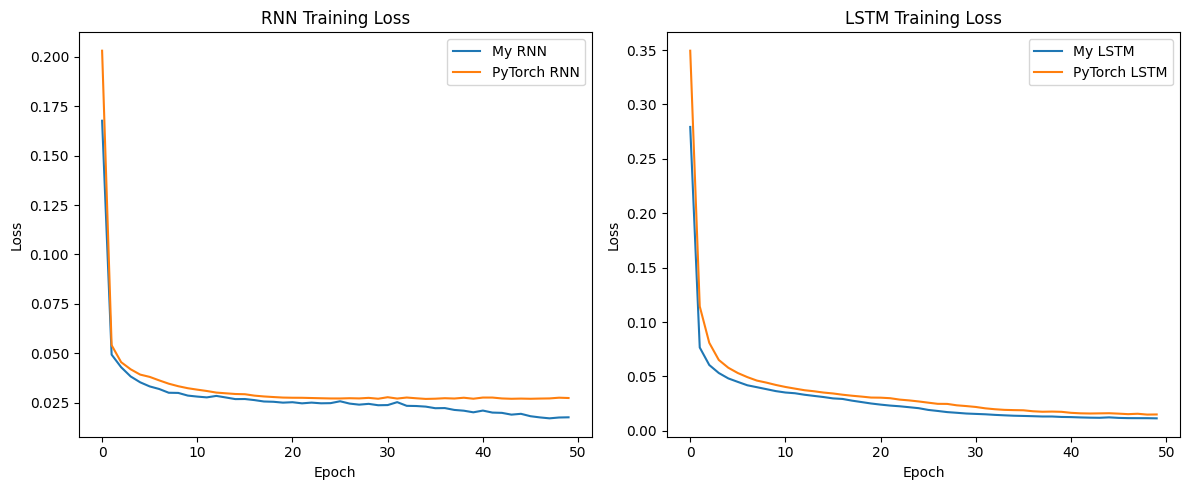

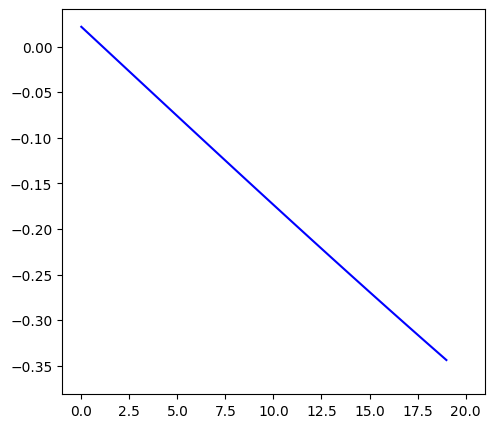

In [14]:
# Set random seed for reproducibility
from matplotlib import pyplot as plt


torch.manual_seed(42)
np.random.seed(42)
    
# Parameters
input_size = 1
hidden_size = 64
output_size = 1
seq_length = 20
pred_steps = 1
    
# Generate data
X, y = generate_sine_wave_data(seq_length, num_samples=1000, input_size=input_size, pred_steps=pred_steps)
    
# Split into train and test sets (80/20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
    
# Initialize models
my_rnn_model = my_rnn(input_size, hidden_size, output_size)
my_lstm_model = my_lstm(input_size, hidden_size, output_size)
torch_rnn_model = torch_rnn(input_size, hidden_size, output_size)
torch_lstm_model = torch_lstm(input_size, hidden_size, output_size)
    
# Train models
print("Training Custom RNN Model...")
my_rnn_losses = train_model(my_rnn_model, X_train, y_train, epochs=50)
    
print("\nTraining Custom LSTM Model...")
my_lstm_losses = train_model(my_lstm_model, X_train, y_train, epochs=50)
    
print("\nTraining PyTorch RNN Model...")
torch_rnn_losses = train_model(torch_rnn_model, X_train, y_train, epochs=50)
    
print("\nTraining PyTorch LSTM Model...")
torch_lstm_losses = train_model(torch_lstm_model, X_train, y_train, epochs=50)
    
# Test models
print("\nTesting models...")
my_rnn_preds, targets, my_rnn_mse = test_model(my_rnn_model, X_test, y_test)
my_lstm_preds, _, my_lstm_mse = test_model(my_lstm_model, X_test, y_test)
torch_rnn_preds, _, torch_rnn_mse = test_model(torch_rnn_model, X_test, y_test)
torch_lstm_preds, _, torch_lstm_mse = test_model(torch_lstm_model, X_test, y_test)
    
print(f"Custom RNN MSE: {my_rnn_mse:.4f}")
print(f"Custom LSTM MSE: {my_lstm_mse:.4f}")
print(f"PyTorch RNN MSE: {torch_rnn_mse:.4f}")
print(f"PyTorch LSTM MSE: {torch_lstm_mse:.4f}")
    
# Plot training losses
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(my_rnn_losses, label='My RNN')
plt.plot(torch_rnn_losses, label='PyTorch RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training Loss')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(my_lstm_losses, label='My LSTM')
plt.plot(torch_lstm_losses, label='PyTorch LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.legend()
    
plt.tight_layout()
    
# Plot sample predictions
sample_idx = 0  # just take the first test sample for visualization
    
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(seq_length), X_test[sample_idx, :, 0], 'b-', label='Input Sequence')
plt.plot(np.arange(seq_length, seq_length + pred_steps), targets[sample_idx, :, 0], 'g-', label='True')
plt.plot(np.arange(seq_length, seq_length + pred_steps), my_rnn_preds[sample_idx, :, 0], 'r--', label='My RNN')
plt.plot(np.arange(seq_length, seq_length + pred_steps), torch_rnn_preds[sample_idx, :, 0], 'm--', label='PyTorch RNN')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('RNN Predictions')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(np.arange(seq_length), X_test[sample_idx, :, 0], 'b-', label='Input Sequence')
plt.plot(np.arange(seq_length, seq_length + pred_steps), targets[sample_idx, :, 0], 'g-', label='True')
plt.plot(np.arange(seq_length, seq_length + pred_steps), my_lstm_preds[sample_idx, :, 0], 'r--', label='My LSTM')
plt.plot(np.arange(seq_length, seq_length + pred_steps), torch_lstm_preds[sample_idx, :, 0], 'm--', label='PyTorch LSTM')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
    
plt.tight_layout()
plt.show()